# **Garbage Classification**

Mounts your Google Drive to access files.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. **Data Preparation**
This section involves setting up the dataset, defining custom transformations for data augmentation, and creating data loaders for training, testing, and validation sets.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Defining a custom dataset class to load images, get the length, item and paths.

In [ ]:
# Define the custom dataset class
class CustomDataset(Dataset):
    def __init__(self, data_dir, classes, transform=None):
        self.data_dir = data_dir
        self.classes = classes
        self.num_classes = len(classes)
        self.image_paths = self.get_image_paths()
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path, label = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_image_paths(self):
        image_paths = []
        for i, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.data_dir, class_name)
            if os.path.isdir(class_dir):
                for image_name in os.listdir(class_dir):
                    if image_name.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp')):
                        image_path = os.path.join(class_dir, image_name)
                        image_paths.append((image_path, i))
        return image_paths

# Specifing the directory and classes for dataset.

In [ ]:
# Set the directory where your dataset is located
data_dir = '/content/drive/MyDrive/TrashType_Image_Dataset'
classes = ['metal', 'paper', 'glass', 'trash', 'plastic', 'cardboard']

# Defining transformations for data augmentation and transformations for validation.

In [ ]:
# Define transformations for data augmentation
trash_augmentation = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),  # Increased rotation for trash images
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Assuming RGB images
])

other_augmentation = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Assuming RGB images
])

# Define transformations for validation (no data augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Assuming RGB images
])

# Creating custom dataset instances for training and validation and Merges both datasets.

In [ ]:
# Create custom dataset instances for training and validation
train_dataset_trash = CustomDataset(os.path.join(data_dir, 'trash'), classes, transform=trash_augmentation)
train_dataset_other = CustomDataset(data_dir, classes, transform=other_augmentation)
val_dataset = CustomDataset(data_dir, classes, transform=val_transforms)

# Merge both datasets
train_dataset = torch.utils.data.ConcatDataset([train_dataset_trash, train_dataset_other])

# **2. Model Setup**
Here, the pre-trained ResNet-18 model is loaded and modified for the classification task. Loss function, optimizer, and device allocation are also defined in this part.

In [ ]:
# Split the dataset into training and testing sets
total_samples = len(train_dataset)
train_size = int(0.75 * total_samples)
test_size = total_samples - train_size
train_dataset, test_dataset = random_split(train_dataset, [train_size, test_size])

# Define batch size for data loaders
batch_size = 32

# Create data loaders for training and testing sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size*2, num_workers=4)

# Create validation data loader
val_loader = DataLoader(val_dataset, batch_size=batch_size*2, num_workers=4)

# Load pre-trained ResNet-18 model
resnet18 = models.resnet18(pretrained=True)

# Modify the last layer to match the number of classes in your dataset
num_classes = len(classes)
resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001, weight_decay=1e-5)  # Adding weight decay

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

# Defines a function to train the model and plot confusion matrix

In [ ]:
# Train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=15):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f}")

    # Validation phase
    model.eval()
    val_loss = 0.0
    corrects = 0
    total = 0
    predicted_labels = []
    true_labels = []
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)
        total += labels.size(0)
        predicted_labels.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_acc = corrects.double() / total
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Calculate additional metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels, average='weighted')
    recall = recall_score(true_labels, predicted_labels, average='weighted')
    f1 = f1_score(true_labels, predicted_labels, average='weighted')
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

    # Plot confusion matrix
    plot_confusion_matrix(confusion_matrix(true_labels, predicted_labels, normalize=None), classes=classes)

# Function to plot confusion matrix
def plot_confusion_matrix(confusion_matrix, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# **3. Training**
In this section, the training loop is implemented to train the model using the training data loader. The model's performance is monitored during training, and the training loss is printed for each epoch.

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/15, Train Loss: 1.1187
Epoch 2/15, Train Loss: 0.8380
Epoch 3/15, Train Loss: 0.7117
Epoch 4/15, Train Loss: 0.6385
Epoch 5/15, Train Loss: 0.5727
Epoch 6/15, Train Loss: 0.5314
Epoch 7/15, Train Loss: 0.4707
Epoch 8/15, Train Loss: 0.4543
Epoch 9/15, Train Loss: 0.3856
Epoch 10/15, Train Loss: 0.3626
Epoch 11/15, Train Loss: 0.3898
Epoch 12/15, Train Loss: 0.3643
Epoch 13/15, Train Loss: 0.2868
Epoch 14/15, Train Loss: 0.3556
Epoch 15/15, Train Loss: 0.2838
Val Loss: 0.2098, Val Acc: 0.9343
Accuracy: 0.9343, Precision: 0.9400, Recall: 0.9343, F1-score: 0.9355


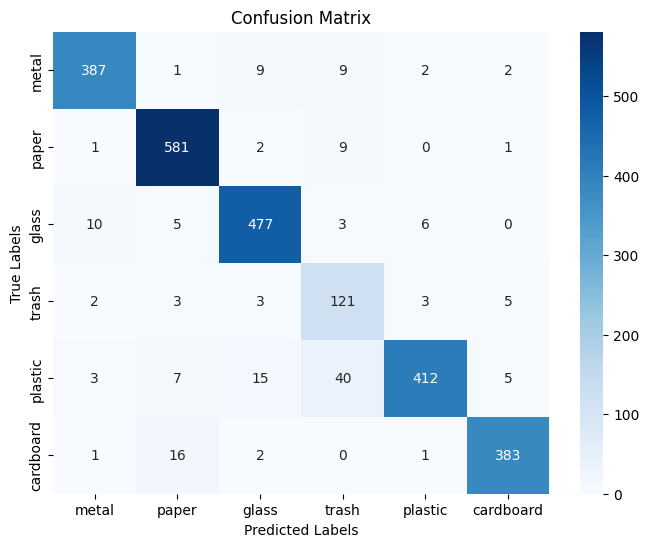

In [ ]:
# Train the model
train_model(resnet18, train_loader, val_loader, criterion, optimizer, num_epochs=15)

# Defines a function to predict new images.

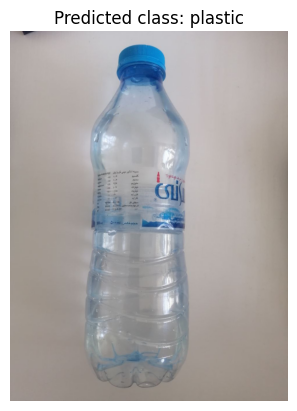

In [ ]:
# Function to predict new images
def predict_image(model, image_path, transform):
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        model.eval()
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)
    predicted_class = classes[predicted.item()]
    return predicted_class, image

# Example usage:
new_image_path = '1.jpg'
predicted_class, image = predict_image(resnet18, new_image_path, val_transforms)
plt.imshow(image)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()


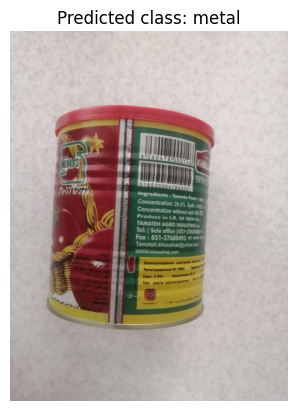

In [ ]:
new_image_path = '2.jpg'
predicted_class, image = predict_image(resnet18, new_image_path, val_transforms)
plt.imshow(image)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

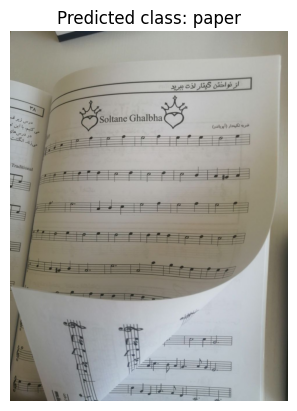

In [ ]:
new_image_path = '3.jpg'
predicted_class, image = predict_image(resnet18, new_image_path, val_transforms)
plt.imshow(image)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

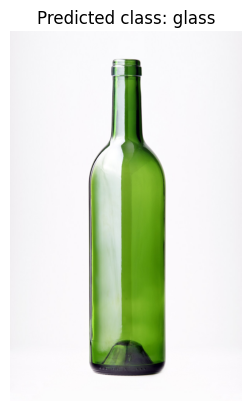

In [ ]:
new_image_path = '4.jpg'
predicted_class, image = predict_image(resnet18, new_image_path, val_transforms)
plt.imshow(image)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

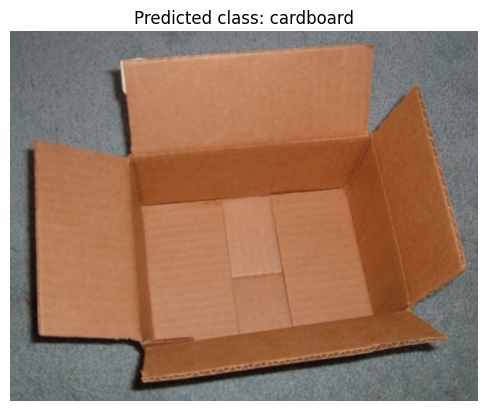

In [ ]:
new_image_path = '5.jpg'
predicted_class, image = predict_image(resnet18, new_image_path, val_transforms)
plt.imshow(image)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()

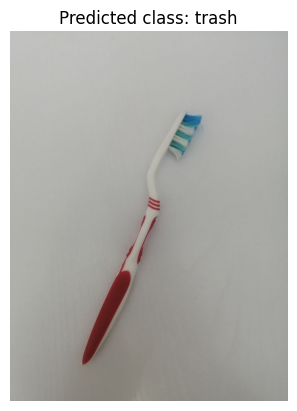

In [ ]:
new_image_path = '6.jpg'
predicted_class, image = predict_image(resnet18, new_image_path, val_transforms)
plt.imshow(image)
plt.title(f"Predicted class: {predicted_class}")
plt.axis('off')
plt.show()